## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, roc_auc_score

from pysim import SimClassifier

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

```python
from pysim import SimClassifier
clf = SimClassifier(method="first_order", reg_lambda=0.1, reg_gamma=10, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Usage**

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=10, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = \sin{(u\pi)} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 1 / (1 + np.exp(-(np.dot(x, beta)))) + 0.05 * np.random.randn(n_samples)
y = y - np.mean(y)
y[y <= 0] = 0
y[y > 0] = 1

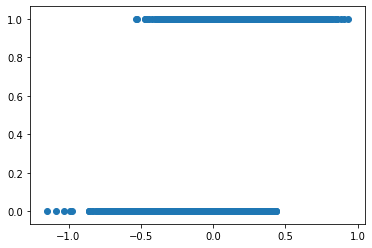

In [3]:
plt.scatter(np.dot(x, beta), y)

The best hyperparameter combination can be selected via cross-validation

In [4]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.01, 0.05, 0.1],
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SimClassifier(degree=2, knot_num=20, random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  90 | elapsed:   14.8s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  55 out of  90 | elapsed:   31.8s remaining:   20.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   36.2s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 2.45 s, sys: 7.36 s, total: 9.81 s
Wall time: 36.5 s


In [5]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 10.0, 'reg_lambda': 0.01}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [6]:
clf = grid.best_estimator_
clf

SimClassifier(degree=2, knot_num=20, method='first_order', random_state=0,
              reg_gamma=10.0, reg_lambda=0.01)

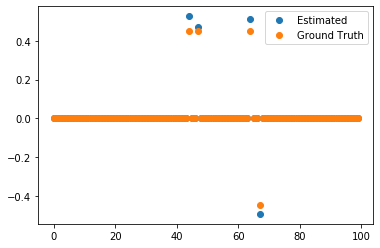

In [7]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

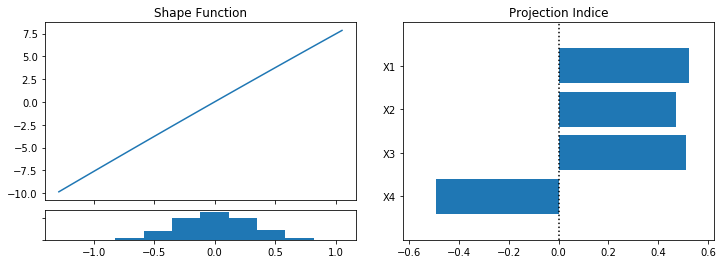

In [8]:
grid.best_estimator_.visualize()

In [9]:
roc_auc_score(y, grid.predict_proba(x))

0.8827909198558643

## Case 2: Quadratic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = u^{2} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [10]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

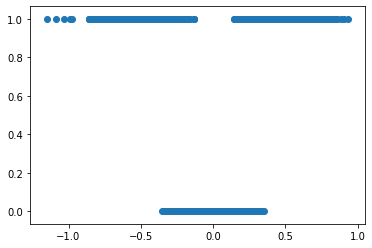

In [11]:
plt.scatter(np.dot(x, beta), y)

In [12]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.01, 0.05, 0.1],
              "reg_gamma": np.logspace(-1, 1, 3)}
grid = GridSearchCV(SimClassifier(degree=2, knot_num=20, random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  54 | elapsed:    9.4s remaining:   36.9s
[Parallel(n_jobs=-1)]: Done  39 out of  54 | elapsed:   14.1s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   15.4s finished


CPU times: user 4.63 s, sys: 11.5 s, total: 16.1 s
Wall time: 15.9 s


In [13]:
grid.best_params_

{'method': 'second_order', 'reg_gamma': 1.0, 'reg_lambda': 0.05}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [14]:
clf = grid.best_estimator_
clf

SimClassifier(degree=2, knot_num=20, method='second_order', random_state=0,
              reg_gamma=1.0, reg_lambda=0.05)

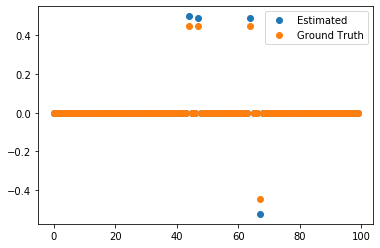

In [15]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

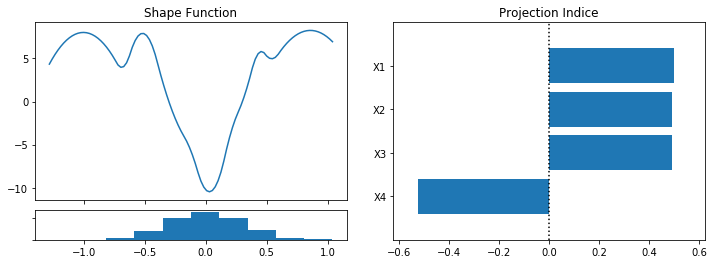

In [16]:
grid.best_estimator_.visualize()

## Case 3: Improve a rough estimator with inner update

In [18]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

In [19]:
%%time 

clf = SimClassifier(degree=2, knot_num=20, reg_lambda=0.05, random_state=0)
clf.fit(x, y)

CPU times: user 4.07 s, sys: 9.48 s, total: 13.5 s
Wall time: 273 ms


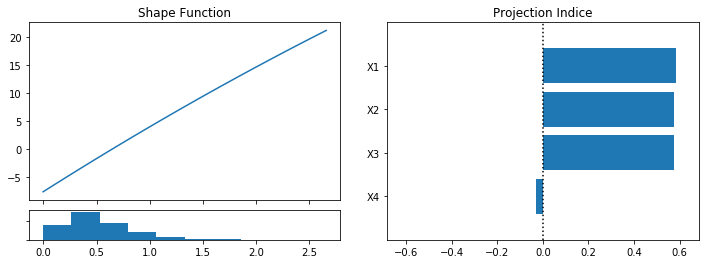

In [20]:
clf.visualize()

**Remark**：The data does not follow a normal distribution, so the performance is relatively poor.

In [21]:
clf.fit_inner_update(x, y, max_inner_iter=10, epoches=10, n_iter_no_change=1,
                     batch_size=100, val_ratio=0.2, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, verbose=True)

Inner iter: 0 epoch: 0 with validation loss: 0.26283
Inner iter: 0 epoch: 1 with validation loss: 0.25634
Inner iter: 0 epoch: 2 with validation loss: 0.24938
Inner iter: 0 epoch: 3 with validation loss: 0.24269
Inner iter: 0 epoch: 4 with validation loss: 0.23541
Inner iter: 0 epoch: 5 with validation loss: 0.2274
Inner iter: 0 epoch: 6 with validation loss: 0.21668
Inner iter: 0 epoch: 7 with validation loss: 0.21603
Inner iter: 0 epoch: 8 with validation loss: 0.20325
Inner iter: 0 epoch: 9 with validation loss: 0.19797


/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/pysim.py:218: RuntimeWarning: divide by zero encountered in log
  val_loss = np.average(- val_y * np.log(val_p) - (1 - val_y) * np.log(1 - val_p),
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/pysim.py:218: RuntimeWarning: invalid value encountered in multiply
  val_loss = np.average(- val_y * np.log(val_p) - (1 - val_y) * np.log(1 - val_p),
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/pysim.py:218: RuntimeWarning: divide by zero encountered in log
  val_loss = np.average(- val_y * np.log(val_p) - (1 - val_y) * np.log(1 - val_p),
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/pysim.py:218: RuntimeWarning: invalid value encountered in multiply
  val_loss = np.average(- val_y * np.log(val_p) - (1 - val_y) * np.log(1 - val_p),
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/pysim.py:218: RuntimeWarning: divide by

Inner iter: 9 epoch: 0 with validation loss: 0.24501
Inner iter: 9 epoch: 1 with validation loss: 0.23375
Inner iter: 9 epoch: 2 with validation loss: 0.22748
Inner iter: 9 epoch: 3 with validation loss: 0.21268
Inner iter: 9 epoch: 4 with validation loss: 0.2047


/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/pysim.py:218: RuntimeWarning: divide by zero encountered in log
  val_loss = np.average(- val_y * np.log(val_p) - (1 - val_y) * np.log(1 - val_p),
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/pysim.py:218: RuntimeWarning: invalid value encountered in multiply
  val_loss = np.average(- val_y * np.log(val_p) - (1 - val_y) * np.log(1 - val_p),


In [25]:
from sklearn.metrics import log_loss
log_loss([1, 0],
        [[.1, .9], [.9, .1]])


0.10536051565782628

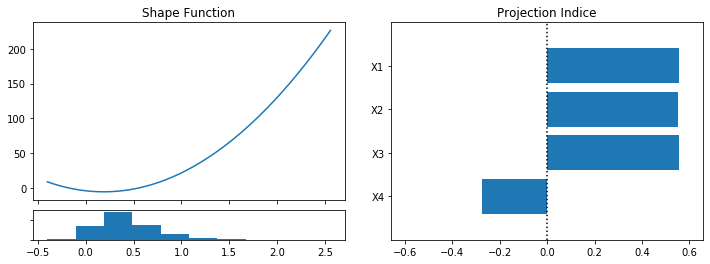

In [22]:
clf.visualize()